In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import codecs
import networkx as nx
from sklearn.cluster import KMeans


In [2]:
files = os.listdir('data/')
sns.set_context('poster')
sns.set_theme()

In [3]:
def catch(x):
    try:
        return int(x)
    except:
        return None


In [4]:
def get_test_data(df, p_id = 0):
    # Drop rows with missing data in column: 'parent index'
    df = df.dropna(subset=['parent index'])
    # Drop columns: 'trials.thisRepN', 'trials.thisTrialN' and 109 other columns
    df = df[['parent index', 'left child index', 'right child index', 'left distance', 'right distance', 'path_resp.keys', 'path_resp.rt']]
    df['p_id'] = p_id
    return df.reset_index(drop=True)
df_test_p = []
tool_order_p = []


for i, f in enumerate(files):
    # print(f)
    if f.endswith('log') or f.endswith('psydat'):
        continue
    df = pd.read_csv(f'data/{f}')
    try:
        df_test_temp = get_test_data(df.copy(), f.split('_')[0])
        tool_order_temp = np.array([catch(x) for x in df['tools'][0].strip('][]').split(' ') if catch(x) != None])
        if len(df_test_temp) != 200:# or len(tool_order_temp) != 12:
            print('short', f)
            continue
        df_test_p.append(df_test_temp)
        tool_order_p.append(tool_order_temp)
        # distance_matrix = np.array(ast.literal_eval(df['distance matrix'][0].replace('\n', ',').replace('.', ','))).astype(int)
    except:
        print(f)        
        continue

df_test = pd.concat(df_test_p).reset_index(drop=True)
tool_order = np.array(tool_order_p)


short 189071_eb_02psyexp_2023-05-16_15h06.27.276.csv
329270_eb_02psyexp_2023-05-16_15h10.52.968.csv
542_eb_02psyexp_2023-05-15_09h47.04.442.csv
543_eb_02psyexp_2010-12-28_07h31.41.842.csv
545_eb_02psyexp_2010-12-28_08h32.50.344.csv
546_eb_02psyexp_2023-05-15_11h00.19.011.csv
547_eb_02psyexp_2023-05-15_10h48.42.920.csv
548_eb_02psyexp_2023-05-15_10h32.40.081.csv
549_eb_02psyexp_2023-05-15_10h34.49.861.csv
550_eb_02psyexp_2023-05-15_10h45.52.565.csv


In [5]:
for node in ['parent', 'left child', 'right child']:
    df_test[f'{node} community'] = 'A'
    df_test.loc[df_test[f'{node} index'] > 5, f'{node} community'] = 'B'


In [6]:
df_test['left shared with parent'] = df_test['parent community'] == df_test['left child community']
df_test['right shared with parent'] = df_test['parent community'] == df_test['right child community']

df_test.loc[((~df_test['left shared with parent']) & (df_test['right shared with parent'])), 'shared with parent'] = 'right'
df_test.loc[((df_test['left shared with parent']) & (df_test['right shared with parent'])), 'shared with parent'] = 'both'
df_test.loc[((~df_test['left shared with parent']) & (~df_test['right shared with parent'])), 'shared with parent'] = 'neither'
df_test.loc[((df_test['left shared with parent']) & (~df_test['right shared with parent'])), 'shared with parent'] = 'left'


C:\Users\tejas\AppData\Local\Temp\ipykernel_29412\1657111397.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_participant = df_test.groupby(['p_id', 'left > right', 'left - right distance', 'shared with parent']).mean().reset_index()


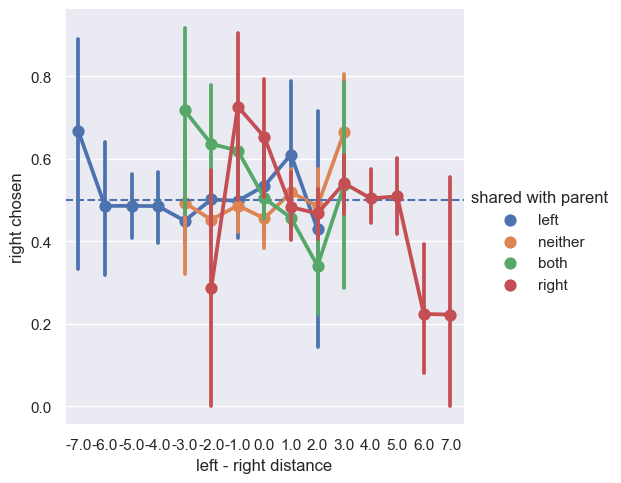

In [7]:
df_test['left > right'] = df_test['left distance'] - df_test['right distance'] > 0
df_test['left - right distance'] = df_test['left distance'] - df_test['right distance']
df_test['right chosen'] = df_test['path_resp.keys'] == 'right'
df_test_participant = df_test.groupby(['p_id', 'left > right', 'left - right distance', 'shared with parent']).mean().reset_index()
df_test_participant
g = sns.catplot(x = 'left - right distance', y = 'right chosen', hue = 'shared with parent',
            kind = 'point', 
            data = df_test_participant)
g.axes[0][0].axhline(y = .5, xmin = -7, xmax = 7, ls = '--')

In [9]:
#0 and 11 are most remote nodes
#1, 2, 9, 10 are less remote nodes
#3, 4, 7, 8 are community nodes
#5, 6 are boundary nodes

In [8]:
for column in ['left child', 'right child', 'parent']:
    df_test[f'{column} identity'] = 'less remote'
    df_test.loc[((df_test[f'{column} index'] == 0) | (df_test[f'{column} index'] == 11)), f'{column} identity'] = 'remote'
    df_test.loc[((df_test[f'{column} index'] == 5) | (df_test[f'{column} index'] == 6)), f'{column} identity'] = 'boundary'
    df_test.loc[((df_test[f'{column} index'] == 3) | (df_test[f'{column} index'] == 4) | (df_test[f'{column} index'] == 7) | (df_test[f'{column} index'] == 8)), f'{column} identity'] = 'community'


C:\Users\tejas\AppData\Local\Temp\ipykernel_29412\2055059859.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_participant = df_test.groupby(['p_id', 'left > right', 'left - right distance', 'shared with parent', 'left child identity', 'right child identity', 'parent identity']).mean().reset_index()


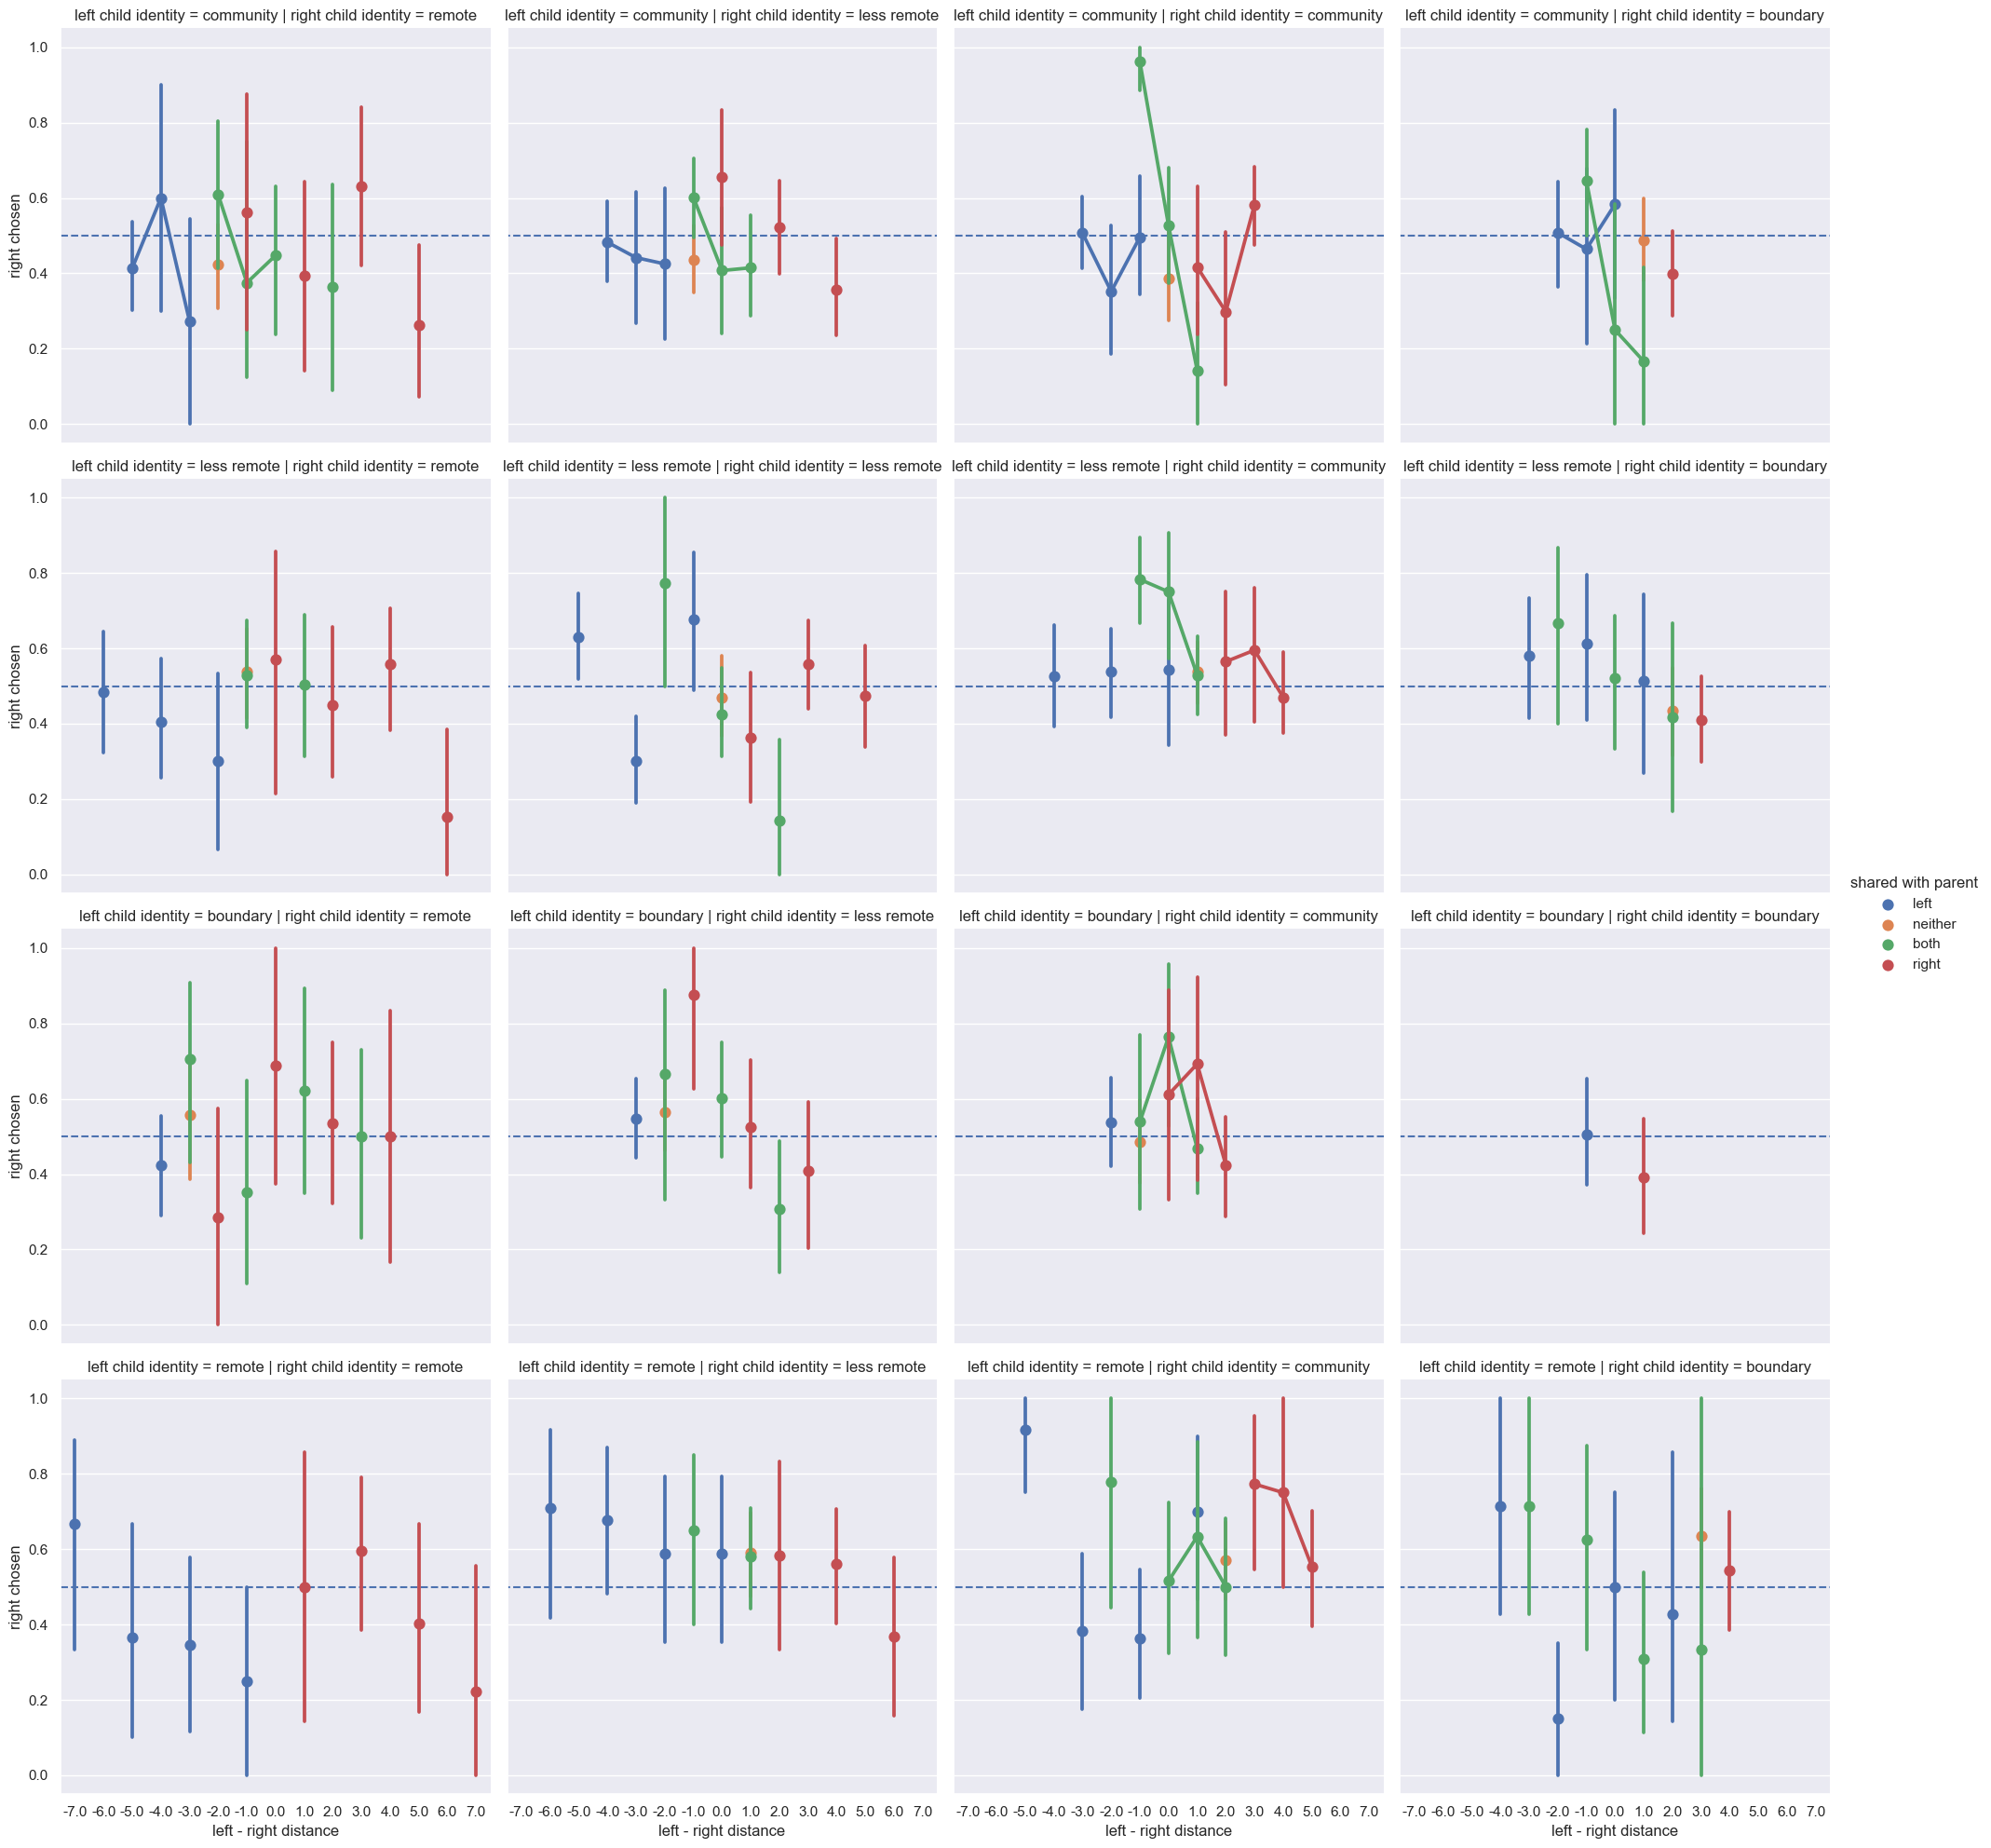

In [9]:
# df_test['left > right'] = df_test['left distance'] - df_test['right distance'] > 0
# df_test['left - right distance'] = df_test['left distance'] - df_test['right distance']
# df_test['right chosen'] = df_test['path_resp.keys'] == 'right'
df_test_participant = df_test.groupby(['p_id', 'left > right', 'left - right distance', 'shared with parent', 'left child identity', 'right child identity', 'parent identity']).mean().reset_index()
df_test_participant
g = sns.catplot(x = 'left - right distance', y = 'right chosen', hue = 'shared with parent', col = 'right child identity', row = 'left child identity',
            kind = 'point', 
            data = df_test_participant)

for i in range(4):
    for j in range(4):
        g.axes[i][j].axhline(y = .5, xmin = -7, xmax = 7, ls = '--')



In [11]:
df_test.to_csv('df_test.csv')

In [12]:
df_train_concat = []
df_tools_concat = []
df_acc_rt_concat = [] 
tool_order_concat = []
for filename in os.listdir('data/'):
    if not filename.endswith('log'):
        if filename.endswith('csv'):
            df = pd.read_csv('data/'+filename)
            tool_order_temp = [catch(x) for x in df['tools'][0].strip('][]').split(' ') if catch(x) != None]

            accuracy = [acc for acc in df.loc[df['small_large_keyresp.corr'].notna(), 'small_large_keyresp.corr']]
            rt = np.array([acc for acc in df.loc[df['small_large_keyresp.corr'].notna(), 'small_large_keyresp.rt']])

            if len(accuracy) != 1000:
                continue
            df_acc_rt_p = pd.DataFrame({'accuracy' : accuracy, 'rt': rt})
            df_acc_rt_p['p_id'] = filename.split('_')[0]
            df_acc_rt_p['trial'] = np.arange(1000)
            df_tools_p = pd.DataFrame({'p_id': filename.split('_')[0], 'tool_order': tool_order_temp})

            df_acc_rt_concat.append(df_acc_rt_p)
            df_tools_concat.append(df_tools_p)

        continue
    
    thisFile = codecs.open('data/'+ filename, 'r', 'utf-8')
    trial = 0
    image_presented = []
    for line in thisFile.readlines():
        if "New trial (" in line:  # new trial reset all entries
            image = ''
            trial += trial 
        elif "image: image =" in line:  # setting an image so get it's name (in quote)
            image_presented.append(int(line.split('/')[-1].split('.')[0]))
    if len(image_presented) != 1600:
        continue
    df_train_p = pd.DataFrame({'image presented' : image_presented[:1000]})
    df_train_p['p_id'] = filename.split('_')[0]
    df_train_p['trial'] = np.arange(1000)
    df_train_concat.append(df_train_p)

    

df_train_stim = pd.concat(df_train_concat)
df_train_resp = pd.concat(df_acc_rt_concat)
df_tools = pd.concat(df_tools_concat)

In [13]:
df_train = pd.merge(
    df_train_stim, 
    df_train_resp, 
    on=['p_id', 'trial']                                    
)
df_train['block'] = np.tile(np.repeat(np.arange(5), 200), len(df_train['p_id'].unique()))
for p_id in df_train['p_id'].unique():
    df_train.loc[df_train['p_id'] == p_id, 'tool index'] = [np.where(x == df_tools.loc[df_tools['p_id'] == p_id, 'tool_order'].values)[0][0] for x in df_train.loc[df_train['p_id'] == p_id, 'image presented'].values]
    

In [14]:
df_train['identity'] = 'less remote'
df_train.loc[((df_train['tool index'] == 0) | (df_train['tool index'] == 11)), 'identity'] = 'remote'
df_train.loc[((df_train['tool index'] == 5) | (df_train['tool index'] == 6)), 'identity'] = 'boundary'
df_train.loc[((df_train['tool index'] == 3) | (df_train['tool index'] == 4) | (df_train['tool index'] == 7) | (df_train['tool index'] == 8)), 'identity'] = 'community'
df_train['source'] = df_train.groupby('p_id')['identity'].shift()


In [15]:
df_train.to_csv('df_train.csv')

In [2]:
df_train = pd.read_csv('df_train.csv')

In [4]:
df_train = df_train[np.abs(scipy.stats.zscore(df_train['rt'])) < 3] #Removing outliers

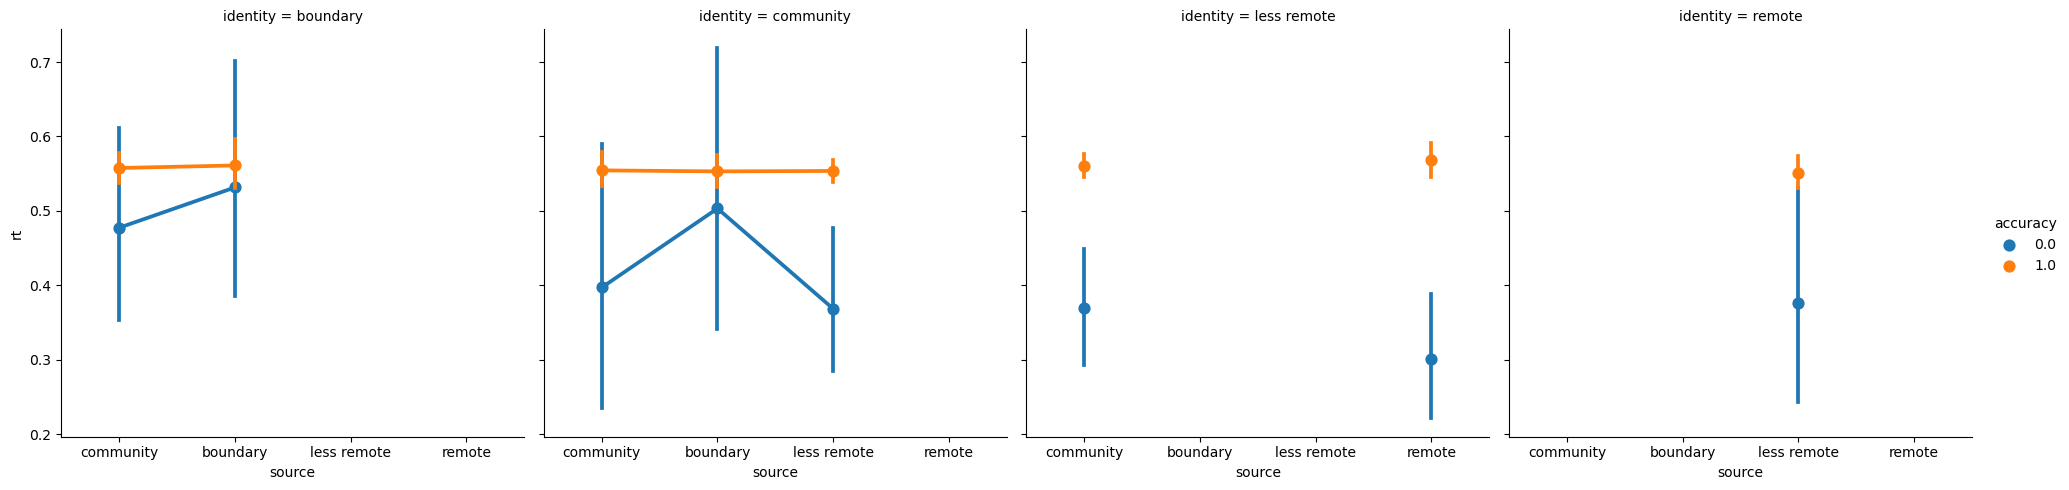

In [10]:
sns.catplot(col='identity', y = 'rt',  data = df_train.loc[df_train['block'] == 4], hue = 'accuracy', kind = 'point', x = 'source')

# HSSM Modeling

In [144]:
import hssm
hssm.set_floatX("float32")
import pymc as pm
import arviz as az

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [145]:
df_train['response'] = [1 if i == 1 else -1 for i in df_train['accuracy']]

In [148]:
model = hssm.HSSM(
    data=df_train.dropna(), 
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (block|p_id) + identity + source"
            
            # "formula": "v ~ 1 + (block|p_id) + identity + source"

        },
        {
            "name": "t",
            "formula": "t ~ 1 + (block|p_id) + identity + source"
            
            # "formula": "v ~ 1 + (block|p_id) + identity + source"

        }

    ]
)

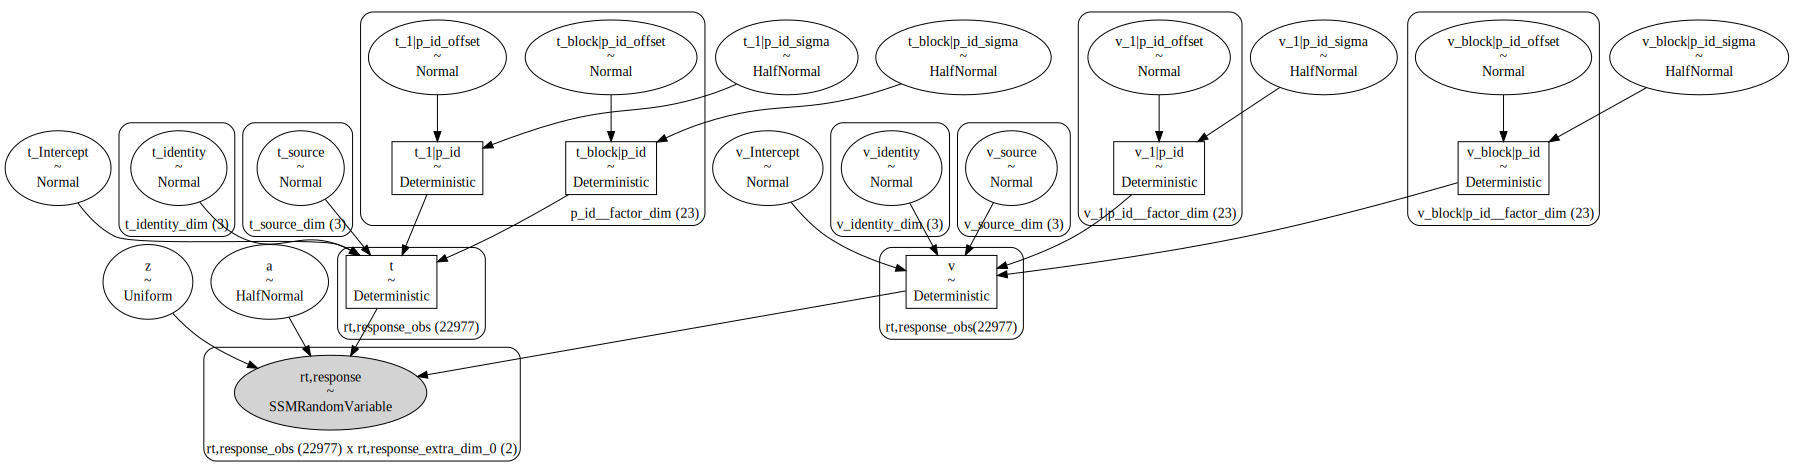

In [149]:
model.graph()

In [150]:
model_sampled = model.sample()

c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\pytensor\tensor\elemwise.py:781: RuntimeWarning: invalid value encountered in sqrt
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\pytensor\tensor\elemwise.py:781: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\pytensor\tensor\elemwise.py:781: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_

In [ ]:
# adj_list = {0:[1, 2], 
# 1:[0, 3, 4],
# 2:[0, 3, 4],
# 3:[1, 2, 4, 5],
# 4:[1, 2, 3, 5],
# 5:[3, 4, 6],
# 6:[5, 7, 8],
# 7:[6, 8, 9, 10],
# 8:[6, 7, 9, 10],
# 9:[7, 8, 11],
# 10:[7, 8, 11],
# 11:[9, 10]
# }


# SR Modeling

In [105]:
# fig, ax = plt.subplots()

def draw_SR_categories(cutoff_point, path = None, alpha = 0.1, gamma = 0.1, num_nodes = 15, ax = None):
    # ax.clear()
    SR = np.random.uniform(0, 1, size=(num_nodes, num_nodes))
    start_state = int(path[0])
    current_state = start_state    
    # cmap = plt.cm.rainbow


    for i, observed_state in enumerate(path[:cutoff_point]):

        expected_probs = SR[current_state]
        one_hot_obs = np.zeros(num_nodes)
        one_hot_obs[int(observed_state)] = 1

        SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

        SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
        SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
        current_state = int(observed_state)    


    G = nx.Graph() 


    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(SR)
#     gm = GaussianMixture(n_components=3, random_state=0, reg_covar=0.05).fit(SR)
    node_color = []
    node_transparency = []
    clusters_assigned = kmeans.predict(SR)
    centroids = kmeans.cluster_centers_
    
#     print(distances)

#     print(prob, cluster)
#     print(prob)
    for node in range(num_nodes):
        node_distance = np.linalg.norm(SR[node] - centroids, axis=1)

#         node_confidences = np.exp(-node_distance / 2) / np.sum(np.exp(-node_distance / 2), axis=0)
        node_confidences = scipy.special.softmax(1/node_distance)
        node_transparency.append(node_confidences)
        # print(node_confidences)
        
        

        if kmeans.labels_[node] == 0:
#         if cluster[node] == 0:
            node_color.append('red')
        else:# kmeans.labels_[node] == 1:
#         elif cluster[node] == 1:
            node_color.append('green')
        # else:
        #     node_color.append('blue')
        
        G.add_node(str(node))

    print(len(node_color))

            
    for i in range(SR.shape[0]):
        for j in range(SR.shape[1]):
            G.add_edge(str(i), str(j), weight = SR[i][j])    
            
    edges = G.edges
    weights = [SR[int(u)][int(v)] for u,v in edges]

    node_pos = nx.spring_layout(G)
    node_labels = np.arange(num_nodes).astype(str)

    nx.draw_networkx_nodes(G, pos=node_pos, nodelist=G.nodes)#, ax = ax)
    nx.draw_networkx_edges(G, pos=node_pos, width=weights, ax = ax)
    nx.draw_networkx_labels(G, pos = node_pos, ax = ax)
    # print(G)
    
    # nx.draw(G, width = weights, with_labels = True)#, alpha = node_transparency)
    
    # plt.show()
    # return 

In [119]:
np.random.choice(df_train['p_id'].unique())

154754

c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


12


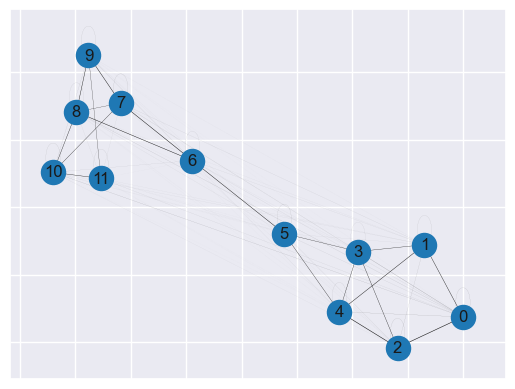

In [143]:
df_train = pd.read_csv('df_train.csv').drop('Unnamed: 0', axis = 1)
path = df_train.loc[df_train['p_id'] == np.random.choice(df_train['p_id'].unique()), 'tool index'].values
draw_SR_categories(1000, path, num_nodes=12, alpha=.04)

In [133]:
path

1000    8.0
1001    9.0
1002    8.0
1003    6.0
1004    7.0
       ... 
1995    8.0
1996    7.0
1997    9.0
1998    8.0
1999    9.0
Name: tool index, Length: 1000, dtype: float64

KeyError: 0

In [ ]:
draw_SR_categories(1000, path = df_train[''], )